In [1]:
import os
import tarfile
import urllib
import pandas as pd

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

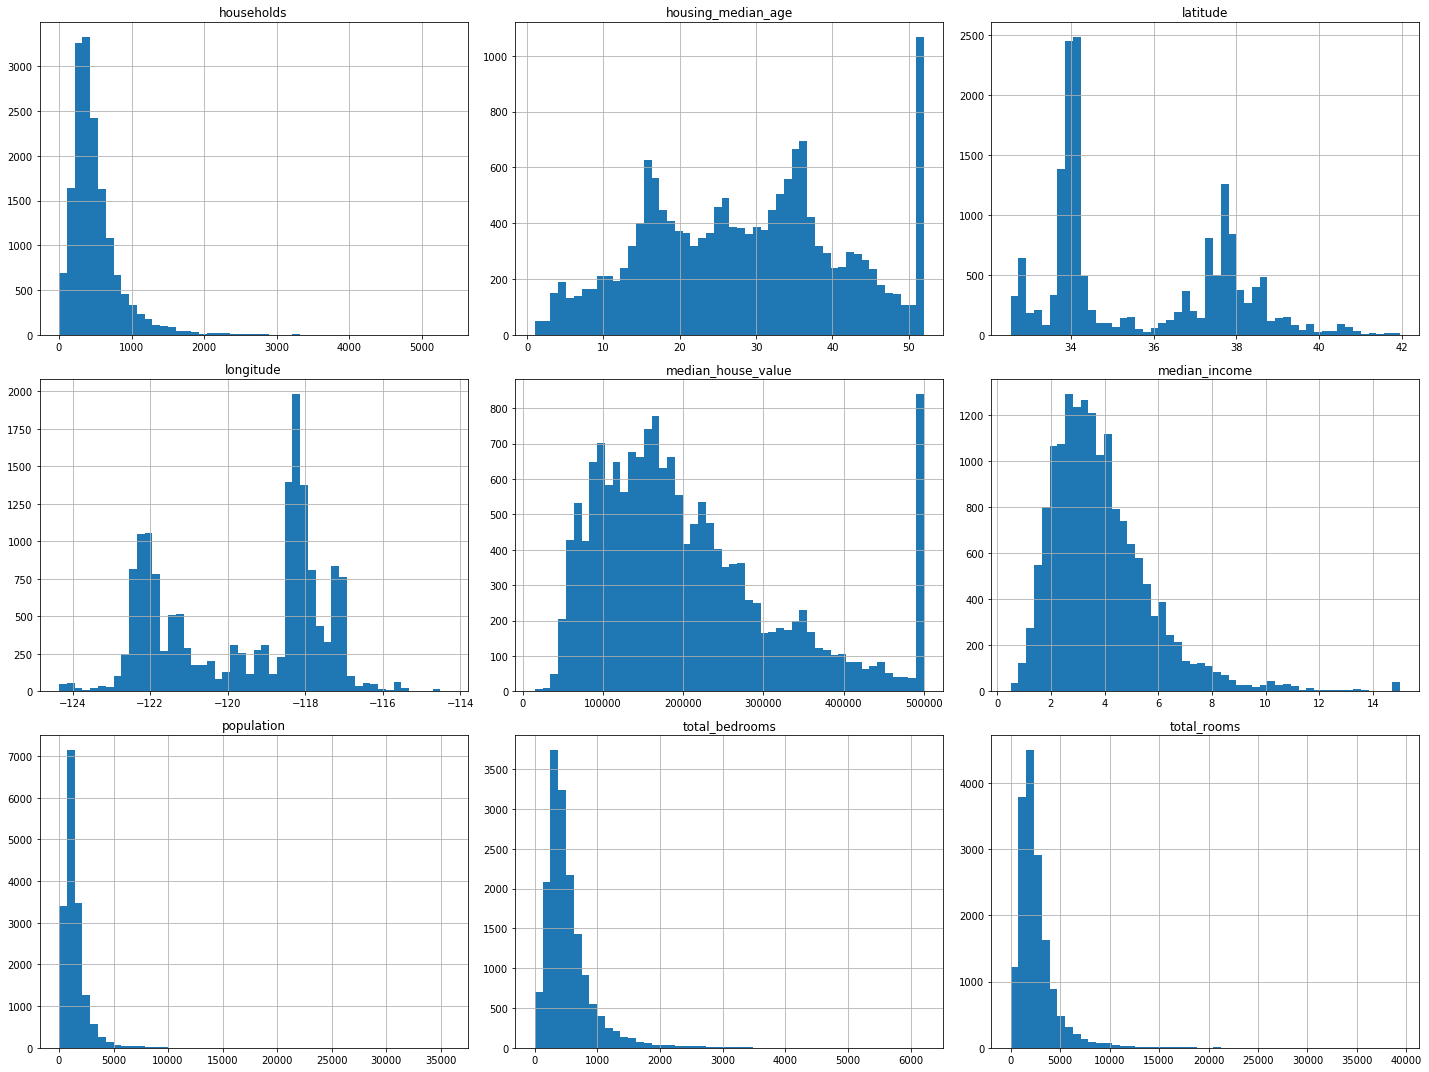

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

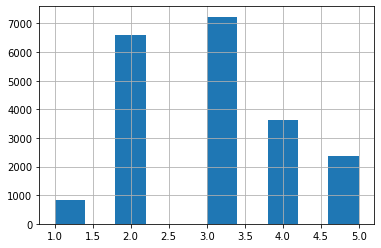

In [5]:
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing["income_cat"].hist()

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [7]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

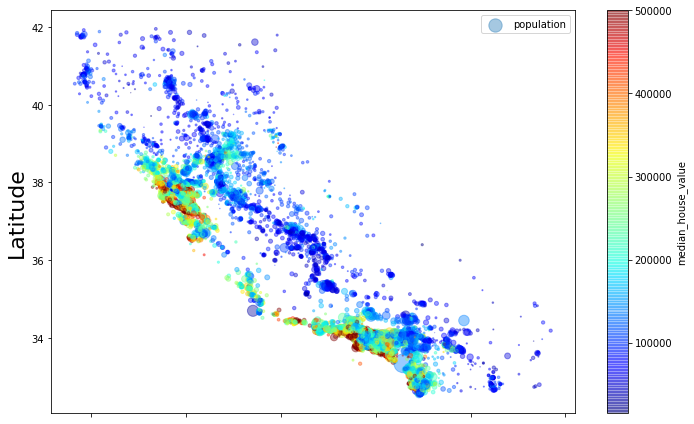

In [42]:
housing = strat_train_set.copy()
ax = housing.plot(kind="scatter", x = "longitude", y = "latitude", alpha = 0.4, s=housing["population"]/100,
            label="population", figsize=(10,6), cmap=plt.get_cmap("jet"), c="median_house_value",
             colorbar=True)
#plt.ylabel("Latitude")
#plt.xlabel("Longitude")
ax.set_ylabel("Latitude", fontsize=22)
ax.set_xlabel("Longitude", fontsize=22)
plt.tight_layout()




In [46]:
# now check for correlations
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
# shows a STRONG POSITIVE correlation between house value and the median income.
# and a SLIGHT NEGATIVE correlation between house value and latitude (lower price the futher north the property)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

done


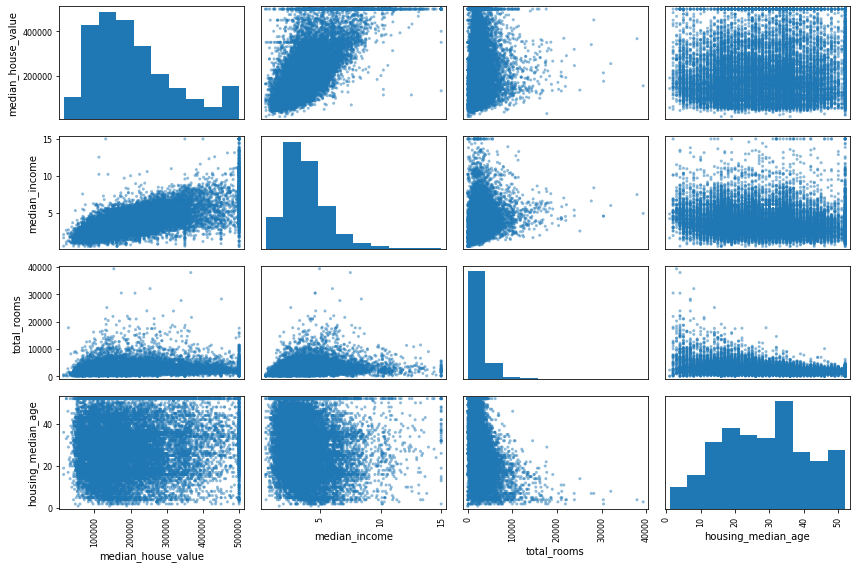

In [51]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
# shows a strong correlation between median income and house value
print ("done")

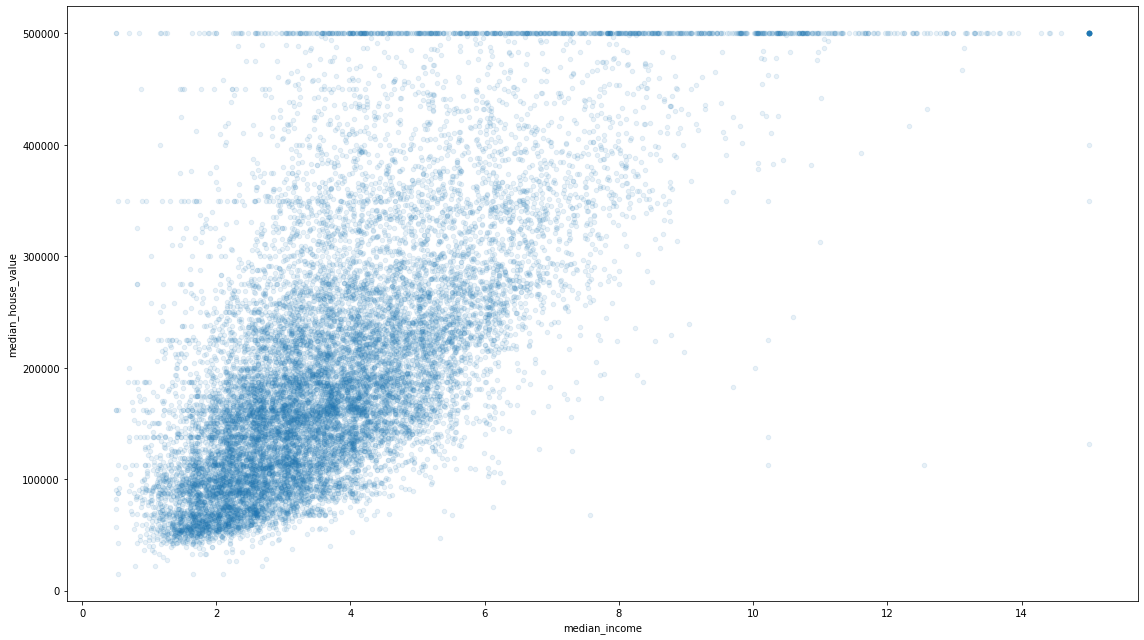

In [55]:
# looking more closely we can look specifically at the median age correlation.
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(16,9))
# this allows us to see obivous quirks in the data, namely the cap at 500'000, something at 450k and 350k.

In [57]:
# lets add some new, calculated attributes
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [58]:
# recalculate the correlation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [62]:
# now we've performed some initial data analysis, it's time to clean up the data based on the knowledge we've gained
# first revert back to our clean data set.
housing = strat_train_set.drop("median_house_value", axis=1) #create copy of training data with our label column dropped
housing_labels = strat_train_set["median_house_value"].copy()

#drop total bedrooms
housing.drop("total_bedrooms", axis=1)


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,1356.0,356.0,4.0625,<1H OCEAN


In [75]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)


In [79]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [82]:
# should convert text categories to numerical counterparts.
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [85]:
# to avoid problems with ML algorirthms considering the closeness of ordinal values 
# i.e. 0-4 0-OCEAN is closer to 1-INLAND and not 4-NEAR OCEAN... we can encode instead as a sparse matrix of 
# 0's and 1's.  so we have 1,0,0,0,0  0,1,0,0,0    0,0,1,0,0 instead.
# we can use a OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [134]:
# create a new class to combine attributes dynamically. 
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


In [93]:
# define transformation pipeline to combine steps for data preparation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # for normalization (feature scaling)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('attribs_header', CombinedAttributesAdder()),
    ('std_scalar', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [99]:
#  use column transformer to handle the categorical columns (OCEAN_PROXIMITY) and combine into pipeline
from sklearn.compose import ColumnTransformer

num_attributes = list(housing_num)
cat_attributes = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
])

# return our transformed and prepared data ready for training
housing_prepared = full_pipeline.fit_transform(housing)


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [136]:
# setup a linear regression model for the prediction
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
predictions = lin_reg.predict(some_data_prepared)
#print("Data: ", list(some_data_prepared),len(list(some_data_prepared)))
print("Predictions: ", list(predictions),len(list(predictions)))
print("Real Values (Labels): ", list(some_labels), len(list(some_labels)))
# note predictions are off by large degree so lets check mean squared error

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Root Mean Squared Error = ", lin_rmse)


Predictions:  [210644.6045928555, 317768.8069721081, 210956.4333117824, 59218.98886849079, 189747.5584987852] 5
Real Values (Labels):  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0] 5
Root Mean Squared Error =  68628.19819848922


In [138]:
# we'll use another more complex model, the DecisionTreeRegressor 
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Root Mean Squared Error = ", tree_rmse)

Root Mean Squared Error =  0.0


In [141]:
# a mean error of 0 ??  this is most likely due to overfitting, 
# so for finer grained validation we'll use cross-validation which performs validation across multiple sets.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores.mean()

71340.36793205306

In [142]:
# ouch, 71'340, is the mean error.. this is actually worse than the original linear regression. 

In [150]:
# we'll try another linear regression model, the randomforestregressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Root Mean Squared Error = ", forest_rmse)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
forest_rmse_scores.mean()

Root Mean Squared Error =  18621.9930857627


50347.130008241

In [155]:
# a much better result, now we will tune the hyperparameters, the params we feed to the regressor to discover which
# set of params works best.. 
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30,40,50], 'max_features': [2, 4, 6, 8, 10, 12]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [158]:
print("best = ", grid_search.best_params_)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print (np.sqrt(-mean_score), params)

best =  {'max_features': 8, 'n_estimators': 50}
63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
52980.36742419779 {'max_features': 2, 'n_estimators': 40}
52522.085382110075 {'max_features': 2, 'n_estimators': 50}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
50143.14410447875 {'max_features': 4, 'n_estimators': 40}
49888.69599493461 {'max_features': 4, 'n_estimators': 50}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
49892.295944853344 {'max_features': 6, 'n_estimators': 40}
49707.39336688697 {'max_features': 6, 'n_estimators': 50}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max

In [160]:
# we get a slight improvment after tuning, giving us 49299.900206837825 {'max_features': 8, 'n_estimators': 50}
# lets look at which features have the biggest impact...

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.07771053e-02, 6.41234817e-02, 4.30905372e-02, 1.48114863e-02,
       1.44659040e-02, 1.49347989e-02, 1.40999632e-02, 3.81445119e-01,
       5.17980839e-02, 1.10770738e-01, 5.16206540e-02, 9.13723773e-03,
       1.53943103e-01, 7.63229721e-05, 1.98963174e-03, 2.91583249e-03])

In [164]:
# this data is not very useful by itself so we'll map it to the column names

extra_attribs = ["rooms_per_household", "pop_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attributes + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38144511908340856, 'median_income'),
 (0.15394310311199735, 'INLAND'),
 (0.11077073840095239, 'pop_per_household'),
 (0.07077710530327438, 'longitude'),
 (0.06412348171823112, 'latitude'),
 (0.05179808394344973, 'rooms_per_household'),
 (0.05162065395189866, 'bedrooms_per_room'),
 (0.043090537232853075, 'housing_median_age'),
 (0.014934798859827295, 'population'),
 (0.014811486251177437, 'total_rooms'),
 (0.014465903995837462, 'total_bedrooms'),
 (0.014099963220482365, 'households'),
 (0.009137237726447504, '<1H OCEAN'),
 (0.002915832490461209, 'NEAR OCEAN'),
 (0.0019896317375760653, 'NEAR BAY'),
 (7.632297212540881e-05, 'ISLAND')]

In [167]:
# our model is now looking good enough to try against our test data

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)  #Preprocess test data

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)  # 47'416



In [168]:
# save the final model
import joblib
joblib.dump(final_model, "ca_housing_price_model.pkl")

['ca_housing_price_model.pkl']